# Lecture 8 Supplemental Notebook

Data 100, Fall 2022

Created by Will Fithian

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style='darkgrid', font_scale = 1.5,
              rc={'figure.figsize':(7,5)})

rng = np.random.default_rng()

## A fake election data set

Suppose that we are trying to run a poll to predict the mayoral election in Gotham City. First, let's grab a data set that has every single voter in Gotham

In [38]:
gotham = pd.read_csv("gotham.csv")
gotham

,age,is.male,vote,vote.dem
0,35,0,Dem,1
1,42,1,Rep,0
2,55,0,Dem,1
3,77,1,Rep,0
4,31,0,Rep,0
...,...,...,...,...
1299995,62,1,Dem,1
1299996,78,1,Dem,1
1299997,68,0,Rep,0
1299998,82,1,Rep,0


What percentage of Gotham voters are planning to vote for the Democratic candidate?

In [55]:
100 * np.mean(gotham["vote.dem"])

53.03669230769231

Suppose we take a convenience sample of everyone who is retired?

In [62]:
convenience_sample = gotham.query("age >= 65")

100 * np.mean(convenience_sample["vote.dem"])

37.36992064463711

Is the sample too small / noisy?

In [63]:
convenience_sample.shape[0]

359396

In [56]:
votes_by_demo = gotham.groupby(["age","is.male"]).agg("mean")
votes_by_demo = votes_by_demo.reset_index()
votes_by_demo

,age,is.male,vote.dem
0,18,0,0.669848
1,18,1,0.816259
2,19,0,0.661966
3,19,1,0.812896
4,20,0,0.655657
...,...,...,...
125,80,1,0.406733
126,81,0,0.250378
127,81,1,0.402704
128,82,0,0.246038


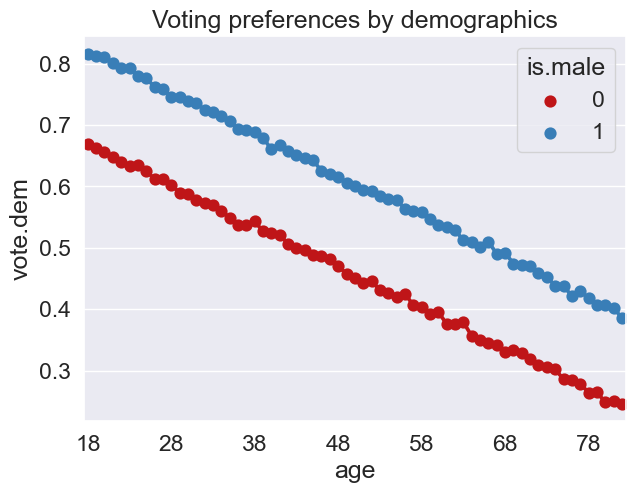

In [94]:
import matplotlib.ticker as ticker
fig = plt.figure();
ed_blue = ["#bf1518", "#397eb7"]
with sns.color_palette(sns.color_palette(red_blue)):
    ax = sns.pointplot(data=votes_by_demo, x = "age", y = "vote.dem", hue = "is.male")

ax.set_title("Voting preferences by demographics")
fig.canvas.draw()
new_ticks = [i.get_text() for i in ax.get_xticklabels()];
plt.xticks(range(0, len(new_ticks), 10), new_ticks[::10]);


What if we instead took a simple random sample? How big would it need to be to outperform our convenience sample?

In [72]:
## By default, replace = False
random_sample = gotham.sample(1000, replace = False)

100 * np.mean(random_sample["vote.dem"])

54.0

### Question:

What if older voters are more likely to answer the phone??